In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
project_path = '/home/ruben/Documents/GitHub/CrisisBureaucracy'
data_path = '/media/ruben/Elements/PhD/data/hansard'

In [3]:
# Load all sentences with 'bureaucracy' (not just annotated set, but everything: 4080 texts)
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/bureaucracy-sentences-full.tsv',sep='\t').dropna()

def load_full(id_):
    f = pd.read_csv(f'{data_path}/lemmatized_pm/uk.proc.d.{id_[:10]}.txt',sep='\t')
    return [list(f[f['id'] == 'uk.proc.d.' + id_]['text'])[0],list(f[f['id'] == 'uk.proc.d.' + id_]['text_lemmatized'])[0]]

    
df['text'] = [load_full("-".join(x.split('-')[1:-1]))[0] for x in tqdm(df['id'])]
df = df[['id','text']]

100%|██████████| 4080/4080 [02:07<00:00, 31.94it/s]


In [4]:
# # Load a sample of 500 debates for TFIDF Vectorizer (> 400.000 speech-paragraphs)
# sample_ = random.sample(gb(f'{data_path}/lemmatized_pm/*'),500)
# sample_df = pd.DataFrame()

# for s in tqdm(sample_):
#     s = pd.read_csv(s,sep='\t')
#     sample_df = sample_df.append(s)
# sample_df = sample_df.dropna().reset_index(drop=True)

100%|██████████| 500/500 [01:50<00:00,  4.51it/s]


In [4]:
# Split metadata to columns
df['year'] = [int(x.split('-')[1]) for x in df.id]
df['party'] = [str(x.split('-')[-1]) for x in df.id]
df['id'] = ["-".join(x.split('-')[1:-1]) for x in df.id]

In [5]:
# Preprocess text (remove stopwords, remove punctuation, lowercase)
df['text'] = utils.preprocess_(df['text'],stopwords=stopwords.words('english') + "hon member friend gentleman gentlemen speaker right".split(' '))

In [51]:
dfs = df#df[df['year'].astype(int).isin(list(range(1969,1975)))].reset_index(drop=True)

In [52]:
dfs['l'] = ["eu" if any(n in t for n in ["brussels","europe","eec","european"]) == True else "other" for t in dfs['text']]

In [53]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [54]:
sid = SentimentIntensityAnalyzer()

In [55]:
list_senti = []
for sentence in dfs['text']:
    ss = sid.polarity_scores(sentence)
    ss = (ss['neg']) / (ss['neu'] + ss['compound'] + ss['pos'])
    list_senti.append(ss)

In [56]:
dfs['polarity'] = list_senti

In [57]:
dfs[dfs['l'] == 'other']['polarity'].mean()

0.5858620537262759

In [58]:
dfs[dfs['l'] == 'eu']['polarity'].mean()

-0.026483099359619223

In [63]:
dfs = dfs[["year","l","polarity"]].groupby(['year','l']).mean().reset_index().pivot(index='year',columns='l',values='polarity').reset_index()

<AxesSubplot:xlabel='year'>

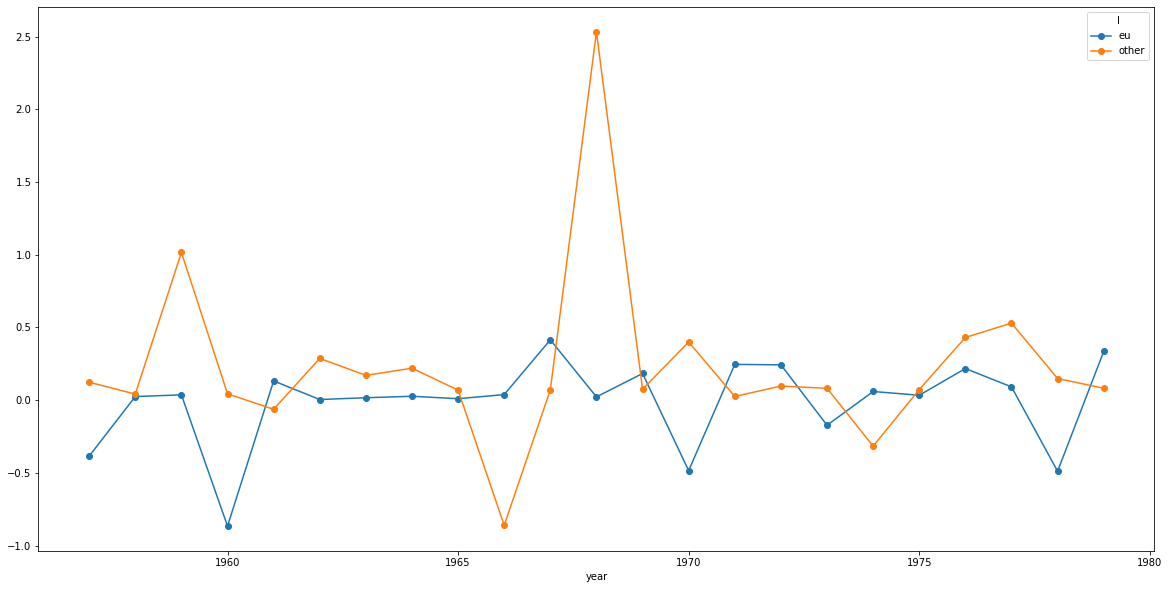

In [67]:
dfs[dfs['year'] <= 1979].plot(x='year',y=['eu','other'],figsize=(20,10),marker='o')

(0.0, 100.0)

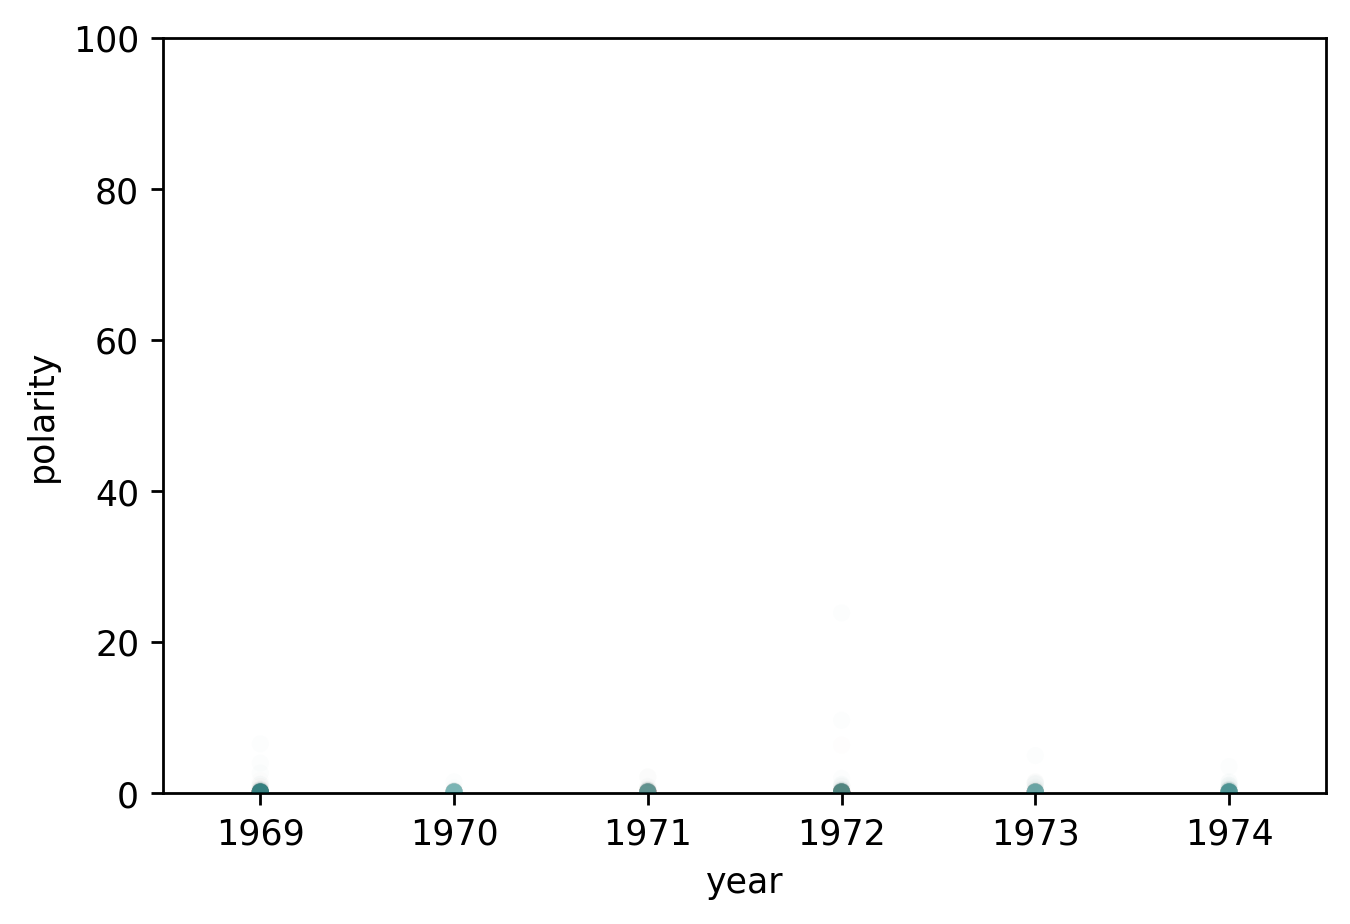

In [43]:
fig = plt.figure(dpi=250)

# sns.stripplot(data=dfs[dfs['l'] == 'eu'],x='year',y='polarity',color='salmon',size=5,alpha=0.01)
# sns.stripplot(data=dfs[dfs['l'] == 'other'],x='year',y='polarity',color='teal',size=5,alpha=0.01)
plt.ylim(0,100)

In [78]:
for c,i in df[(df.text.str.contains('duplication')) & (df.year < 1980)].iterrows():
    print(i['year'],i['party'])
    print(i['text'])
    print('--------------------')

the bodies otherwise the council cannot have authority over the separate bodies we cannot expect that we or the scandinavian countries or poland if she comes in should have authority in a council of europe to control direct or instruct the coal and steel community or euratom unless we are all members this is the only way that we can do it effectively and we might as well face the fact
--------------------
1962 conservative
with regard to enforcement again i am very glad to see that my right hon friend has followed the advice of the gowers committee where we had earnest consideration as to whether we should recommend that there should be a central inspectorate or whether it should be done by the local authorities we were given much evidence on the subject which was very helpful to us we finally came to the conclusion that apart from the factors that my right hon friend mentioned to set up a central inspectorate would involve a large new bureaucracy which would involve a certain amount o

In [75]:
df

,id,text,year,party,l,polarity
0,1957-02-08.5.1.26.11,the other day i was reading a fascinating book...,1957,conservative,eu,0.000000
1,1957-02-08.5.1.49.9,as to this multifariousness this duplication t...,1957,labour,eu,0.070741
2,1957-02-08.5.1.65.3,the intergovernment bodies i have mentioned ar...,1957,labour,eu,0.012664
3,1957-02-08.5.1.79.3,with each organisation and assembly has come a...,1957,conservative,eu,0.000000
4,1957-02-14.16.1.3.2,the history in this case is i fear somewhat ty...,1957,labour,other,0.020160
...,...,...,...,...,...,...
4075,1985-12-11.16.2.18.7,much of the hostility and disaffection felt by...,1985,labour,other,0.054509
4076,1985-12-12.15.1.2.13,my constituents are incensed by the fact that ...,1985,social_democratic_party,other,3.899371
4077,1985-12-17.6.1.1.13,the details of these and other proposals are i...,1985,conservative,other,0.163999
4078,1985-12-18.13.1.18.3,i mention one point that has not been mentione...,1985,conservative,other,-1.046070
